# TP2 - La satisfaction de la clientèle de la SNCF

### Deux jeux de données:

- Le premier est un ensemble de réponses données à un questionnaire de statisfaction collectées par la SNCF. Les notes sont soit entre 0 et 7 (j'espère pour la SNCF...), soit entre 0 et 10.

Infos à l'adresse suivante :

https://data.sncf.com/explore/dataset/barometre-notes-dopinion-sncf/information/?sort=date

Je ai stocké la bdd à l'adresse suivante:

https://raw.githubusercontent.com/llesoil/modelisation_des_problemes_scientifiques-/master/ressources/barometre-notes-dopinion-sncf.csv

-  Le second est une enquête plus détaillée, à plus large échelle. Elle comprend des infos détaillées sur le type de clients dans la train, des baromètres détaillés par date et par gare.

Infos à l'adresse suivante:

https://data.sncf.com/explore/dataset/barometre-client/information/

Je l'ai (un peu modifiée puis) stockée à l'adresse suivante:

https://raw.githubusercontent.com/llesoil/modelisation_des_problemes_scientifiques-/master/ressources/gare_detail.csv


### 1) Importez les librairies numpy et pandas, et le premier jeu de données. Affichez les cinq premières lignes.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_table(filepath_or_buffer = "https://raw.githubusercontent.com/llesoil/modelisation_des_problemes_scientifiques-/master/ressources/barometre-notes-dopinion-sncf.csv", # l'adresse du fichier
              header = 0, # noms de variables en ligne 1
              delimiter =',', # délimiteur, ici la virgule pour un csv
              index_col=0) # l'index de la colonne du nom des individus
data.head()

,Notes_opinion,Experience,Reputation
Date,,,
2014-06,ponctualité,4.3,3.6
2014-08,ponctualité,4.4,3.7
2014-09,ponctualité,4.4,4.0
2014-07,innovation,5.4,5.1
2015-01,innovation,5.5,5.2


### 2) Régression linéaire

### 2) a-] Filtrer les valeurs non manquantes de Experience et Reputation. 

On pourra utiliser la fonction isnan de numpy, trouver le tableau des indices manquants, puis utiliser la fonction setdiff1d de numpy.

In [2]:
def indiceManquant(nomCol):
    # Cette fonction prend en entrée un nom de colonne 
    # et renvoie les indices où les valeurs de data pour cette colonne sont vides
    return np.where(np.isnan(data[nomCol]))

manquants = np.array(indiceManquant('Reputation')+indiceManquant('Experience')).reshape(-1,1)
# On ajoute les indices mmanquants des deux variables considérées, on les met dans un seul tableau
# En l'occurrence, dans ce cas présent, les colonnes sont vides en même temps,
# Mais en pratique ça peut être plus compliqué

nonManquants = np.setdiff1d(range(len(data)),manquants)
# On enlève les manquants à tous les indices pour trouver les non-manquants

### 2) b-] Expliquez la variable Réputation grâce à la variable Experience à l'aide d'une régression linéaire, puis calculez la droite de régression.

Prenez soin de ne garder que les valeurs non-manquantes.

In [3]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

%matplotlib inline 
# pour plotter directement les graphiques

x = data['Experience'][nonManquants] # on ne garde que les non-manquants
y = data['Reputation'][nonManquants]

coef, intercept, r_value, _ , std_err = linregress(x,y)

predictionRep = coef*x+intercept

### 2) c-] Représentez graphiquement la droite de régression et le nuage de points. 

La régression vous parait-elle adaptée? Justifiez en analysant la valeur de la variable r_value.
La comparer au coefficient de corrélation linéaire.

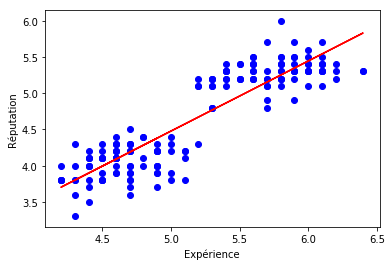

In [4]:
plt.scatter(x, y, color = 'blue')
plt.plot(x, predictionRep, color = 'red')
plt.ylabel("Réputation")
plt.xlabel("Expérience")
plt.show()

In [5]:
r_value**2

0.8105427365945156

Le R² (r_value) est proche de 1, la régression explique bien les données.

In [6]:
print("La corrélation linéaire entre les variables Réputation et Experience vaut", np.corrcoef(x,y)[0,1])
print("Le coefficient de la régression expliquant Expérience par Réputation vaut ", r_value)

La corrélation linéaire entre les variables Réputation et Experience vaut 0.9003014698391398
Le coefficient de la régression expliquant Expérience par Réputation vaut  0.9003014698391398


Dans le cas où l'on explique une variable par une seule autre variable, le R vaut le coefficient de corrélation linéaire. 

### 3) Analyse des Correspondances Multiples

### 3) a-] Transformez les variables Experience et Reputation en variables qualitatives.

Il pourra être utile d'extraire un dataframe ne contenant que des informations renseignées, sans case vide.

In [7]:
# On prend d'abord les lignes non manquantes de la base de données
notes = data[np.invert(np.isnan(data['Experience']))]

# Puis on crée les variables quali associées à experience et réputation grâce à la fonction suivante
def notesQuali(nom):
    expres = notes[nom]
    borne1, borne2 = np.percentile(expres,33), np.percentile(expres,66)
    return np.array(['Faible'*int(k<=borne1) + 'Moyenne'*int(k>borne1 and k <borne2) + 'Bonne'*int(k>=borne2) for k in expres])

#Deux manières éqivalentes de faire la même chose
notes = notes.assign(ExperienceQuali = notesQuali('Experience'))
notes['ReputationQuali'] = notesQuali('Reputation')
notes.head()

,Notes_opinion,Experience,Reputation,ExperienceQuali,ReputationQuali
Date,,,,,
2014-06,ponctualité,4.3,3.6,Faible,Faible
2014-08,ponctualité,4.4,3.7,Faible,Faible
2014-09,ponctualité,4.4,4.0,Faible,Faible
2014-07,innovation,5.4,5.1,Moyenne,Moyenne
2015-01,innovation,5.5,5.2,Moyenne,Bonne


On peut faire un tableau de contingence avec ces deux nouvelles variables

In [8]:
pd.crosstab(notes['ExperienceQuali'], notes['ReputationQuali'])

ReputationQuali,Bonne,Faible,Moyenne
ExperienceQuali,,,
Bonne,56,0,8
Faible,0,53,10
Moyenne,16,19,14


### 3) b-] Créez le tableau disjonctif complet (avec les booléens par individu* les modalités des variables) à l'aide de la fonction get_dummies de pandas

https://fr.wikipedia.org/wiki/Tableau_disjonctif_complet Pour plus d'informations si ça manque de clarté.

On se restreint au dataframe des trois variables suivantes:
- La variable Notes_opinion
- La variable qualitative représentant l'expérience dela question 3) a-]
- La variable qualitative représentant la réputation dela question 3) a-]

In [9]:
res = pd.get_dummies(notes[["Notes_opinion","ExperienceQuali","ReputationQuali"]])
res.head()

,Notes_opinion_globale,Notes_opinion_innovation,Notes_opinion_ponctualité,Notes_opinion_prix,ExperienceQuali_Bonne,ExperienceQuali_Faible,ExperienceQuali_Moyenne,ReputationQuali_Bonne,ReputationQuali_Faible,ReputationQuali_Moyenne
Date,,,,,,,,,,
2014-06,0,0,1,0,0,1,0,0,1,0
2014-08,0,0,1,0,0,1,0,0,1,0
2014-09,0,0,1,0,0,1,0,0,1,0
2014-07,0,1,0,0,0,0,1,0,0,1
2015-01,0,1,0,0,0,0,1,1,0,0


### 3) c-] Faites une Analyse des Correspondances Multiples sur le tableau de la question 3) b-].

On pourra utiliser la fonction MCA du package mca. L'attribut fs_c() de la fonction MCA rend les coordonnées des modalités de variables sur les plans factoriels (par exemple, fs_c()[:,0] rend les coordonnées sur le premier axe).

Puis affichez le premier plan factoriel à l'aide de matplotlib:
- D'abord, affichez les points correspondants aux modalités de variables
- Puis, ajoutez les textes correspondants aux variables à l'emplacement des points (res.columns contient les noms, voir la fonction text() de matplotlib).
- Enfin, si vous souhaitez améliorer la lecture du graphique, vous pouvez ajouter des couleurs spécifiques pour chaque variable. Par exemple rouge pour le type de service noté (Notes_opinion), vert pour la réputation, bleu pour l'expérience.

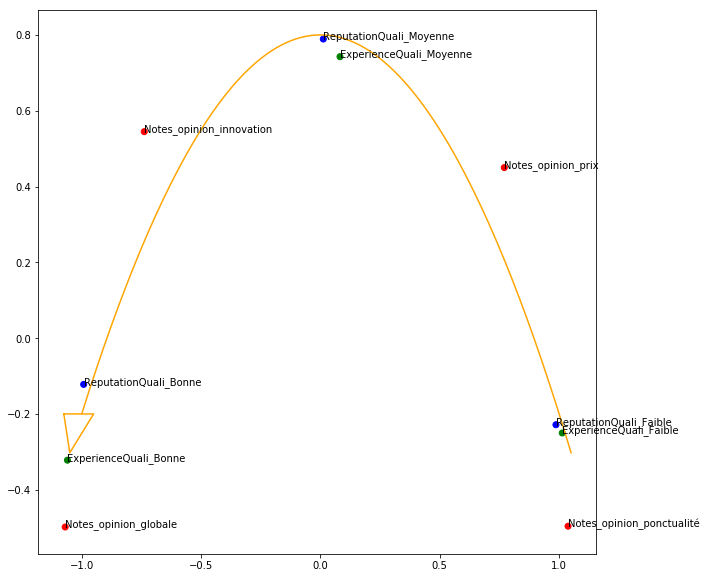

In [10]:
import mca

# On applique la fonction MCA au tableau disjonctif précédent
acm = mca.MCA(res)

# On aggrandit l'échelle, les analyses factorielles ont souvent besoin d'être "aérées" pour être interprétées
plt.figure(figsize=(10,10))

# On affiche les points, avec des couleurs spécifiques aux différentes variables
couleurs = ['red']*4+['green']*3+['blue']*3
plt.scatter(acm.fs_c()[:, 0], acm.fs_c()[:, 1], color=couleurs)

#On affiche les textes
nombreColonnes = len(res.columns)
for indiceVariable in range(nombreColonnes):
    plt.text(x= acm.fs_c()[:, 0][indiceVariable], y = acm.fs_c()[:, 1][indiceVariable], s = res.columns[indiceVariable])



## En plus, je rajoute une flèche orange, pour que l'analyse soit plus facile à faire

# Une fontion hyperbolique pour coller aux variables
xabs = np.linspace(-1,1.05,200)
yabs = [*map(lambda x: 0.8-x*x,xabs)]
plt.plot(xabs,yabs,c="orange")

# la tête de la flèche
x = [-1.075, -1.05, -0.95, -1.075]
y = [-0.2, -0.3025, -0.2, -0.2]
plt.plot(x, y ,c="orange")


#On affiche le graphique
plt.show()

### 3) d-] Analyser les résultats: quel(s) point(s) la scnf doit-elle améliorer en priorité?

On peut sur ce graphe analyser les choses suivantes:
- La sncf est au global assez bien notée
- En terme d'innovation, c'est plutôt positif
- Le prix pourrait être amélioré, mais le plus gros souci des passagers est la ponctualité, peu réputée, qu'ils sanctionnent avec des notes faibles.

J'ai représenté la flèche orange pour mettre en avant que sur ce plan, on peut lire le graphe uniquement en la suivant. C'est en quelque sorte un gradient de qualité/satisfaction.

C'est un cas d'école, un effet Guttman, sous forme hyperbolique. (voir https://books.openedition.org/enseditions/1462?lang=fr pour plus de détails)

### 4) Classification ascendante hiérarchique

### 4) a-] Générez la matrice des distances à l'aide de la fonction linkage du package scipy.cluster.hierarchy

On réutilisera les résultats de l'acm précédente (prendre la matrice des coordonnées de l'acm)

In [11]:
from scipy.cluster.hierarchy import linkage

# Générer la matrice des distances entre les individus
Z = linkage(acm.fs_c(),
            method='ward', # distance
            metric='euclidean')# métrique utilisée

### 4) b-] Affichez le dendogramme correspondant. 

Compte-tenu de l'affichage précédent, pouvez-vous "deviner" quels groupes de variables vont être regroupés?

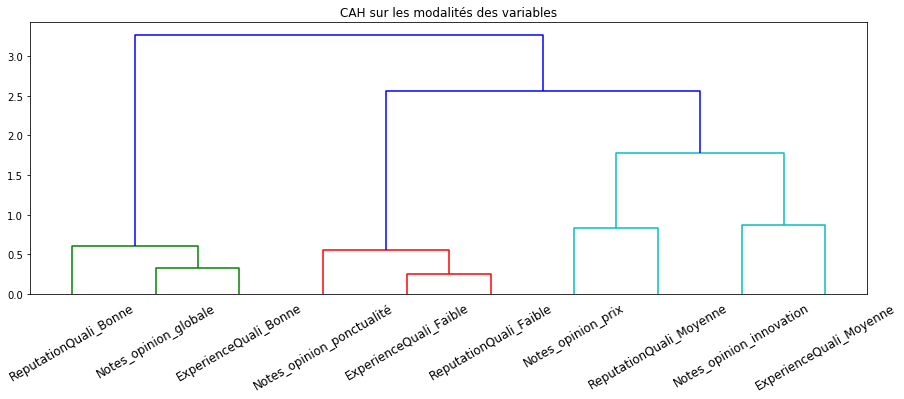

In [12]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(15,5))
plt.title("CAH sur les modalités des variables")
dend = dendrogram(Z, # les distances entre modalités
           labels=[str(k) for k in res.columns], # les labels des variables
           leaf_rotation=30., # la rotation des labels des feuilles du dendogramme
           color_threshold=2) # le niveau de l'arbre pour lequels on "coupe les branches" et on colore les groupes
plt.show()

### 4) c-] Les groupes sont-ils en accord avec vos analyses de la question 3) d-]?

Oui, on retrouve les groupes de l'acm. 

La CAH peut paraitre inutile dans ce cas présent, mais si vous rencontrez un jour des jeux de données avec énormément de variables, vous serez contents d'avoir ce style de vue qui simplifie les choses.

Parfois, le premier plan factoriel ne contient pas assez d'informations, alors que la cah tient compte de toutes les distances (en dimension > 2 si on garde plus d'axes que juste les deux premiers axes). Si vous avez un doute, faites confiance à la cah, et non à  l'affichage du premier plan factoriel.

### 5) Classification

### 5) a-] Importez le second jeu de données

Pour la signification des variables :
- Agence est l'agence associée à la gare (j'imagine qu'une agence gère les gares au niveau régional). DGGP est l'agence pour la région parisienne, je n'ai pas trouvé la signification de l'acronyme.
- Gare correspond à l'identifiant de la gare. Dans la plupart des cas, une ville n'a qu'une seule gare, donc la gare correspond à la ville.
- Global_2018 est la note (de 0 à 10) globale de la gare pour l'année 2018.
- Accessibilite_2018 est la note (de 0 à 10) donnée pour l'accessibilité de la gare pour l'année 2018.
- Proprete_2018 est la note (de 0 à 10) donnée pour la propreté de la gare pour l'année 2018.
- Confort_2018 est la note (de 0 à 10) donnée pour le confort de la gare pour l'année 2018.

Pensez à  imposer aux notes un type float à l'aide de l'option dtype de la fonction read_table de pandas.

In [13]:
gare = pd.read_table(filepath_or_buffer = "https://raw.githubusercontent.com/llesoil/modelisation_des_problemes_scientifiques-/master/ressources/gare_detail.csv", # l'adresse du fichier
              dtype={'Global_2018':float,
                    'Accessibilite_2018':float,
                     'Proprete_2018':float,
                     'Confort_2018':float},
              header = 0, # noms de variables en ligne 1
              delimiter =',')
gare.head()

,Agence,Gare,Global_2018,Accessibilite_2018,Proprete_2018,Confort_2018
0,DGGP,AEROPORT CDG2 TGV ROISSY,7.31,7.94,7.91,7.00
1,DGGP,MARNE LA VALLEE CHESSY,7.35,7.63,7.94,6.67
2,DGGP,MASSY TGV,6.97,7.42,7.95,6.88
3,DGGP,PARIS AUSTERLITZ,6.86,7.59,7.38,6.92
4,DGGP,PARIS BERCY,7.10,7.63,7.69,6.92


### 5) b-] Les gares parisiennes sont-elles bien notées?

In [14]:
gare.groupby('Agence').mean()

,Global_2018,Accessibilite_2018,Proprete_2018,Confort_2018
Agence,,,,
Centre Est Rhone Alpin,7.528182,7.758636,8.030000,7.309545
Centre Ouest,7.447308,7.634231,7.949615,7.194615
DGGP,7.027000,7.578000,7.492000,6.647000
Est Europeen,7.726667,7.930000,8.081667,7.381667
Grand Sud,7.443103,7.651034,7.965172,7.180000
Manche Nord,7.418889,7.693333,7.951667,7.179444
Nouvelle Aquitaine,7.797857,7.834286,8.420000,7.599286


Non, ce sont les pires notes.

### 5) c-] Faire touner un algo KNN à 3 voisins. Quelles sont les deux gares qui ont les résultats les plus proches de la gare de Rennes?

In [15]:
from sklearn.neighbors import NearestNeighbors

X = gare[['Global_2018','Accessibilite_2018','Proprete_2018','Confort_2018']]

nbrs = NearestNeighbors(n_neighbors=3).fit(X)

distances, indices = nbrs.kneighbors(X)

In [16]:
indiceRennes = np.where(gare['Gare']=='RENNES')[0]
indices[indiceRennes]

array([[49,  7,  8]], dtype=int64)

In [17]:
gare.iloc[7]

Agence                              DGGP
Gare                  PARIS GARE DU NORD
Global_2018                         6.51
Accessibilite_2018                  7.11
Proprete_2018                        6.7
Confort_2018                        5.87
Name: 7, dtype: object

In [18]:
gare.iloc[8]

Agence                              DGGP
Gare                  PARIS MONTPARNASSE
Global_2018                         6.76
Accessibilite_2018                  7.62
Proprete_2018                        7.2
Confort_2018                        6.31
Name: 8, dtype: object

C'est peut-être à cause des travaux, mais la gare de Rennes est particulièrement mal notée en 2018. Au global, presque toutes les grandes villes ont l'air d'avoir des mauvais avis.

Fin de la correction

Pour mettre de la couleur dans les jgraphs...

In [19]:
jointure = pd.DataFrame({'Agence' : gare.groupby('Agence').mean().index,
                        'Couleur' : np.array(('0xFF0000', '0x00FF00', '0x0000FF', '0xFFD966', '0xFF66D9', 
                                              '0x66D9FF', '0x66FFD9'))})

gare = gare.set_index('Agence').join(jointure.set_index('Agence'))
gare['Agence']=gare.index
gare = gare.set_index('Gare')
gare.head()

,Global_2018,Accessibilite_2018,Proprete_2018,Confort_2018,Couleur,Agence
Gare,,,,,,
AIX LES BAINS LE REVARD,7.26,7.65,7.85,7.15,0xFF0000,Centre Est Rhone Alpin
ANNECY,7.63,7.98,8.09,7.41,0xFF0000,Centre Est Rhone Alpin
BELFORT MONTBELIARD TGV,8.27,7.33,8.75,8.19,0xFF0000,Centre Est Rhone Alpin
BELLEGARDE,7.57,7.23,8.22,7.48,0xFF0000,Centre Est Rhone Alpin
BESANCON FRANCHE COMTE TGV,7.97,7.27,9.02,7.82,0xFF0000,Centre Est Rhone Alpin


In [20]:
import jgraph as jg

# On initialise le graphe
graph = {
    'nodes': {},
    'edges': []
}

# on initialise chaque noeud, représentant une gare
for i in range(len(gare)):
    graph['nodes'][gare.index[i]] = {'color' : gare.iloc[i]['Couleur']}

# Et on affiche les liaisons associées à l'algo KNN
tab = []
for (i,j,k) in indices:
    tab.append({'source' : gare.index[i], 'target' : gare.index[j]})
    tab.append({'source' : gare.index[i], 'target' : gare.index[k]})
graph['edges'] = tab

# On plotte le graphe
jg.draw(graph)

Chaque agence a sa couleur. Ici, c'est complètement inutile, mais des fois, ça doit pouvoir servir :)